# Visualize impact of window length on prediction performance

**See file [window_lens.ipynb](window_lens.ipynb) for code to compute results and save to CSV.**

In [1]:
from pathlib import Path

CUR_ABS_DIR = Path.cwd().resolve()
PROJ_DIR = (CUR_ABS_DIR / '../../../').resolve()
OUTPUT_DIR = (PROJ_DIR / 'swissrivernetwork/benchmark/outputs/ray_results/').resolve()
DUMP_DIR = (CUR_ABS_DIR / 'outputs/').resolve()

LOAD_LATEST_RESULTS = True

ISSUE_TAG = '<span style="color:red;">[issue]</span> '
INFO_TAG = '<span style="color:blue;">[info]</span> '
SUCCESS_TAG = '<span style="color:green;">[success]</span> '


def print(text=None):
    from IPython.display import display, HTML
    if text is None:
        display(HTML("<br>"))
        return
    text = str(text)
    display(HTML(text))


print(f'{INFO_TAG} Project directory: {PROJ_DIR}')
print(f'{INFO_TAG} Current directory: {CUR_ABS_DIR}')
print(f'{INFO_TAG} Output directory: {OUTPUT_DIR}')
print(f'{INFO_TAG} Dump directory: {DUMP_DIR}')

In [2]:
import pandas as pd
import os


def read_results_from_csv(output_dir: Path, graph_name: str, method: str):
    file_path = os.path.join(output_dir, f'{graph_name}_{method}_window_lens_results.csv')
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        # print(f"{SUCCESS_TAG} Loaded results from {file_path}.")
        return df
    else:
        # print(f"{INFO_TAG} No results found at {file_path}.")
        return pd.DataFrame()


def save_results_to_csv(df: pd.DataFrame, output_dir: Path, graph_name: str, method: str):
    output_dir.mkdir(parents=True, exist_ok=True)
    file_path = os.path.join(output_dir, f'{graph_name}_{method}_window_lens_results.csv')
    df.to_csv(file_path, index=False)
    # print(f"{SUCCESS_TAG} Saved results to {file_path}.")
    return file_path

In [3]:
import numpy as np

WINDOW_LENS = np.concatenate(
    ([1, 3, 5, 7, 15], 30 * np.arange(1, 13), [365], 30 * np.arange(13, 25), 365 * np.arange(2, 11))
)

GRAPH_NAMES = ['swiss-1990', 'swiss-2010', 'zurich']
METHODS = ['lstm_embedding', 'transformer_embedding', 'lstm', 'graphlet', 'stgnn']

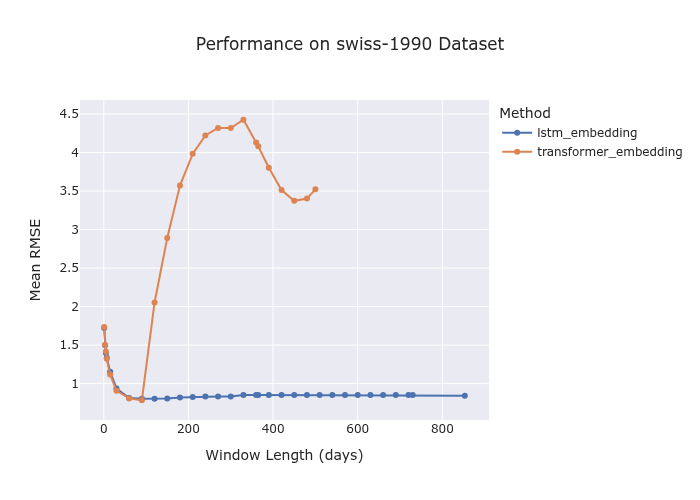

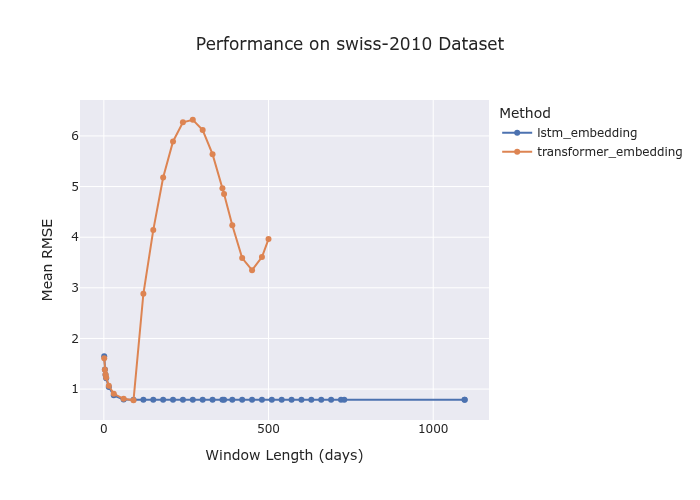

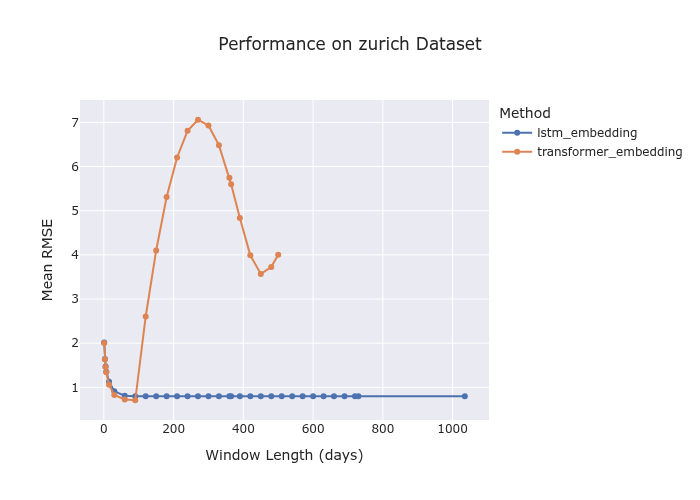

In [4]:
# Plot results from CSV using Plotly (interactive in Jupyter Notebook):

%matplotlib inline


from pathlib import Path
import plotly.io as pio
from IPython.display import Image, display

# Set up Plotly template similar to Seaborn style:
print(pio.templates)
pio.templates.default = "seaborn"

# -----------------------
# Plotting function
# -----------------------


import plotly.express as px


def plot_results_from_csv_plotly(
        dump_dir: Path, graph_name: str, methods: list,
        xlog=False, ylog=False, if_interactive: bool | str = 'both'
):
    import pandas as pd

    # Merge all methods' data into a single DataFrame for plotting:
    df_all = pd.DataFrame()
    for m in methods:
        df_res = read_results_from_csv(dump_dir, graph_name, m)
        if df_res.empty:
            print(f"{ISSUE_TAG} No results to plot for method='{m}' on graph='{graph_name}'. Skipping...")
            continue
        if 'window_len' not in df_res.columns or 'RMSE_Mean' not in df_res.columns:
            print(
                f"{ISSUE_TAG} Missing required columns in results for method='{m}' on graph='{graph_name}'. Skipping..."
            )
            continue
        df_res = df_res[['window_len', 'RMSE_Mean']].copy()
        df_res['method'] = m
        df_all = pd.concat([df_all, df_res], ignore_index=True)

    if df_all.empty:
        print(f"{ISSUE_TAG} No valid data to plot for graph='{graph_name}'.")
        return

    fig = px.line(
        df_all, x='window_len', y='RMSE_Mean', color='method',
        markers=True,
        log_x=xlog,
        log_y=ylog,
        template='seaborn',
        title=f'Performance on {graph_name} Dataset',
        labels={'window_len': 'Window Length (days)', 'RMSE_Mean': 'Mean RMSE', 'method': 'Method'}
    )

    fig.update_layout(hovermode='x unified')

    if str(if_interactive).lower() in ['true', 'both']:
        fig.show()

    if str(if_interactive).lower() in ['false', 'both']:
        # Plotly generates interactive HTML by default, which can not be shown in static platforms like GitHub.
        # Here we convert the figure to a static PNG image for display.
        png_bytes = pio.to_image(fig, format='png')
        display(Image(png_bytes))


for graph_name in GRAPH_NAMES[0:]:
    print()
    print(f'{INFO_TAG} ================= Plotting results for graph="{graph_name}" =================')
    plot_results_from_csv_plotly(DUMP_DIR, graph_name, METHODS[0:2], if_interactive='both')


In [27]:
######## This is the unused version of plotly.graph_objects ########

import plotly.graph_objects as go


def plot_results_from_csv_plotly_go(dump_dir: Path, graph_name: str, methods: list):
    fig = go.Figure()
    has_data = False
    win_len_all = []

    for i, m in enumerate(methods):
        df_res = read_results_from_csv(dump_dir, graph_name, m)
        if df_res.empty:
            print(f"{ISSUE_TAG} No results to plot for method='{m}' on graph='{graph_name}'. Skipping...")
            continue
        if 'window_len' not in df_res.columns or 'RMSE_Mean' not in df_res.columns:
            print(
                f"{ISSUE_TAG} Missing required columns in results for method='{m}' on graph='{graph_name}'. Skipping..."
            )
            continue

        fig.add_trace(
            go.Scatter(
                x=df_res['window_len'],
                y=df_res['RMSE_Mean'],
                mode='lines+markers',
                name=m,
                hovertemplate="Window Len: %{x}<br>RMSE: %{y:.2f}<extra></extra>",
            )
        )
        win_len_all.extend(df_res['window_len'].tolist())
        has_data = True

    if not has_data:
        print(f"{ISSUE_TAG} No valid data to plot for graph='{graph_name}'.")
        return

    fig.update_layout(
        title=f'Performance on {graph_name} Dataset',
        xaxis_title='Window Length (days)',
        yaxis_title='Mean RMSE',
        xaxis=dict(
            tickmode='array',
            # tickvals=sorted(set(win_len_all)),
            # ticktext=[''] * len(set(win_len_all)),
            showgrid=True,
            gridcolor="lightgray",
            zeroline=False,
            # type='log'
        ),
        yaxis=dict(
            showgrid=True,
            gridcolor="lightgray",
            zeroline=False
        ),
        legend_title="Method",
        template="plotly_white",
        hovermode="x unified",
    )

    fig.show()

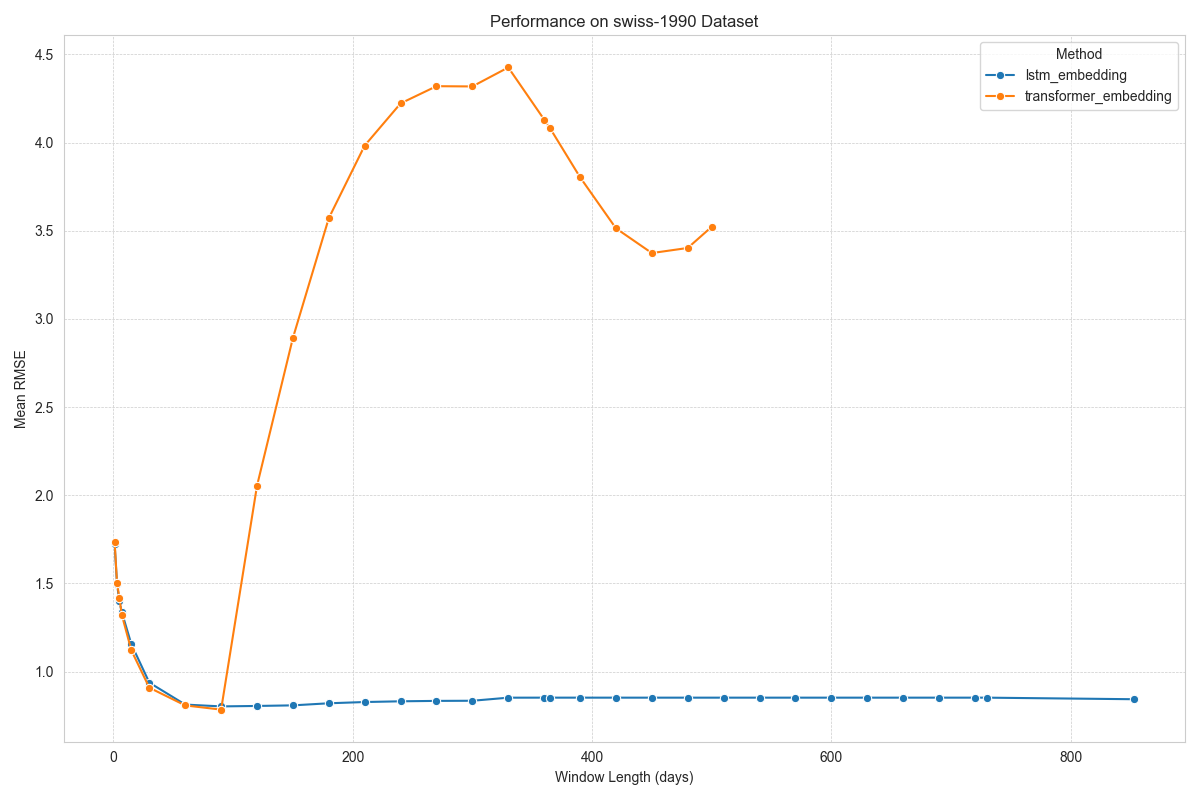

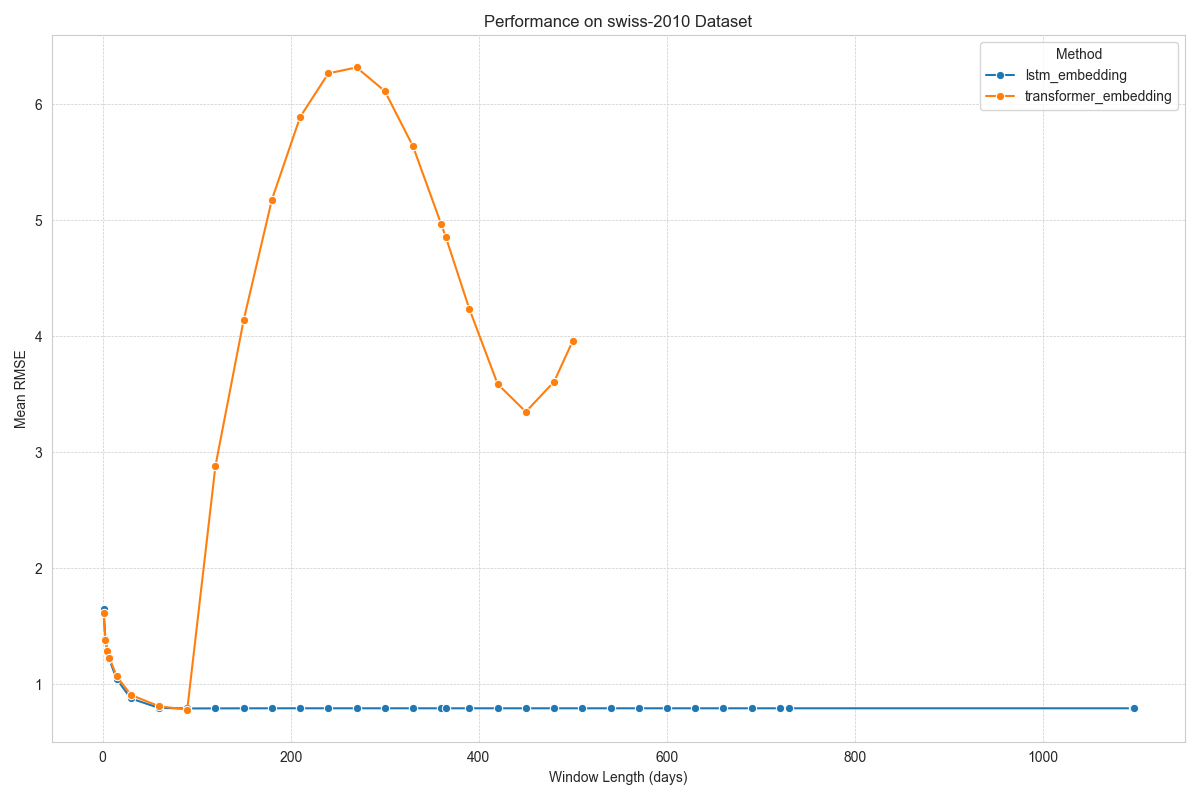

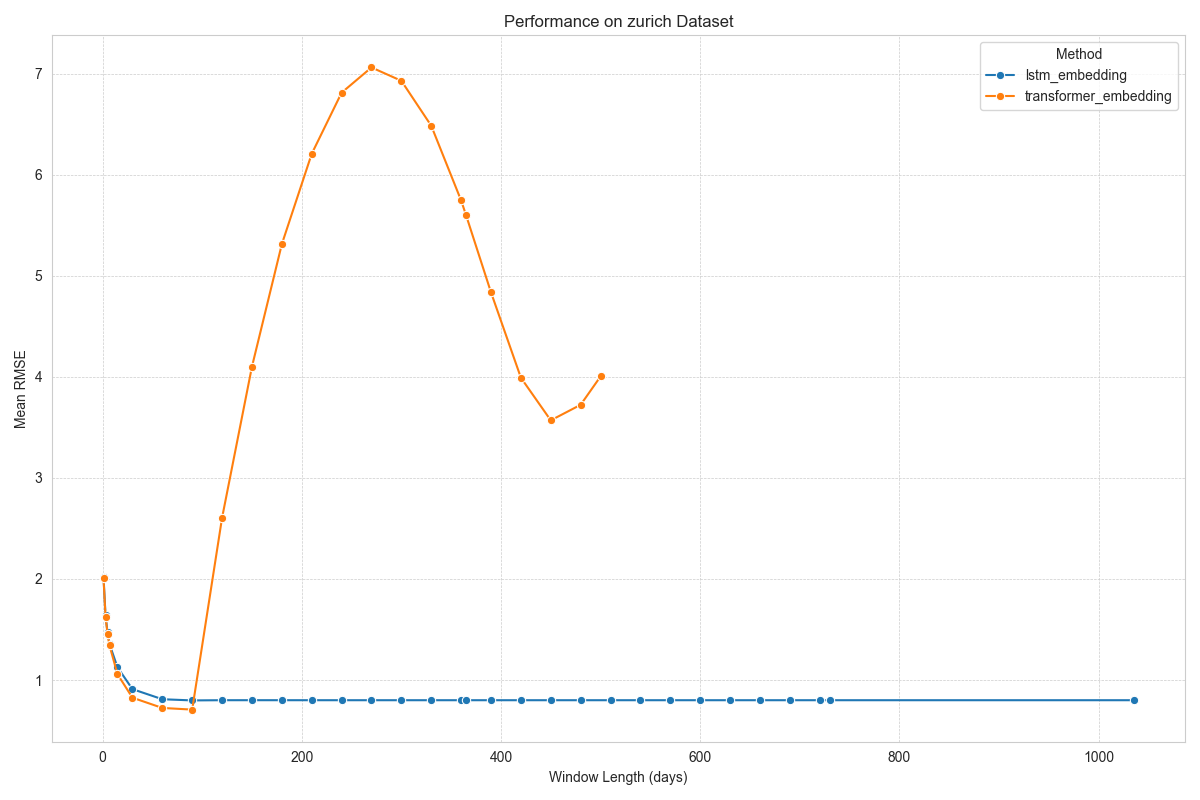

In [28]:
######## This is the unused version of matplotlib with mplcursors ########

# Plot results from CSV, using mplcursors for interactivity:

# must have to be interactive via mplcursors:
%matplotlib widget

import matplotlib.pyplot as plt
import seaborn as sns
import mplcursors


def plot_results_from_csv(dump_dir: Path, graph_name: str, methods: list, if_interactive: bool = True):
    has_data = False
    win_len_all = []

    for m in methods:
        df_res = read_results_from_csv(dump_dir, graph_name, m)
        if df_res.empty:
            print(f"{ISSUE_TAG} No results to plot for method='{m}' on graph='{graph_name}'. Skipping...")
            continue
        if 'window_len' not in df_res.columns or 'RMSE_Mean' not in df_res.columns:
            print(
                f"{ISSUE_TAG} Missing required columns in results for method='{m}' on graph='{graph_name}'. Skipping..."
            )
            continue
        if not has_data:
            plt.figure(figsize=(12, 8))
            ax_plt = plt.gca()
        ax = sns.lineplot(data=df_res, x='window_len', y='RMSE_Mean', marker='o', label=m)
        if not if_interactive:
            for x, y in zip(df_res['window_len'], df_res['RMSE_Mean']):
                ax.text(x, y, f"{y:.2f}", ha='left', va='bottom', fontsize=8)
            win_len_all.extend(df_res['window_len'].tolist())
        has_data = True

    if not has_data:
        print(f"{ISSUE_TAG} No valid data to plot for graph='{graph_name}'.")
        return

    plt.xscale('linear')
    plt.yscale('linear')
    plt.xlabel('Window Length (days)')
    plt.ylabel('Mean RMSE')
    plt.title(f'Performance on {graph_name} Dataset')
    plt.legend(title='Method')
    if not if_interactive:
        plt.xticks(sorted(set(win_len_all)))
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.tight_layout()

    if if_interactive:
        cursor = mplcursors.cursor(ax_plt.lines, hover=True)


        @cursor.connect("add")
        def on_add(sel):
            x, y = sel.target
            sel.annotation.set(text=f"Window Len: {x:.0f}\nRMSE: {y:.2f}")
            sel.annotation.get_bbox_patch().set(fc="white", alpha=0.8)

    plt.show()


for graph_name in GRAPH_NAMES[0:]:
    print()
    print(f'{INFO_TAG} ================= Plotting results for graph="{graph_name}" =================')
    plot_results_from_csv(DUMP_DIR, graph_name, METHODS[0:2], if_interactive=True)